# Getting started (from any data)
The goal is to help you get started with using PlasmaCalcs, from any data you already have, regardless of where it came from.
The idea is that you already have some values, and want to utilize the PlasmaCalcs interface to compute various plasma quantities (e.g., to avoid needing to re-implement the existing formulas), but your data isn't necesarily coming from a source that PlasmaCalcs already knows about. **_Estimated time: 10 minutes_**

This notebook assumes you have already followed the instructions (see the README at https://gitlab.com/Sevans7/plasmacalcs) to install PlasmaCalcs on your machine.

Recommended: copy this notebook to somewhere on your machine (outside of the PlasmaCalcs package), then go through the cells one at a time!  
Use help(obj) for any object you want to know more about.

## Table of Contents:
- [1) Minimal working example](#1\)-Minimal-working-example:-DimensionlessFromDatasetCalculator)
- [2) Working with arrays of data](#2\)-What-if-you-have-arrays-of-data,-though?-(Not-just-a-bunch-of-constants))
- [3) Working with vectors](#3\)-Working-with-vectors)
- [4) Working with time-varying data](#4\)-Working-with-time-varying-data)
- [5) Working with multiple species](#5\)-Working-with-multiple-species)
- [6) Summary, and learning about existing options](#6\)-Summary,-and-learning-about-existing-options)
- [7) Bonus: testing different values / "artificial" scaling](#7\)-Bonus:-testing-different-values-/-"artificial"-scaling)

In [1]:
## imports ##
# builtins
import os   # for os.chdir to navigate to directory where data is stored.

# external packages available via pip install 
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# PlasmaCalcs package
import PlasmaCalcs as pc


## optional / settings ##
import pdb   # --- after a crash, use pdb.pm() to enter the namespace of the crash, for easy debugging!

plt.rcParams['animation.html']='jshtml'  # enables in-line animations in Jupyter

from IPython.display import display, HTML  # set cell width in Jupyter:
display(HTML("<style>.container { width:90% !important; }</style>"))

# xarray options
xr.set_options(display_expand_data=False,
               keep_attrs=True, # -- keep attrs during operations. Note, doesn't handle conflicts, just takes attrs from the first array.
              );
# matplotlib options
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 70  # lower dpi for inline plots makes the Jupyter notebook file smaller.
# EDIT THAT DPI^ TO A LARGER NUMBER (e.g., 300, not 70) TO SEE HIGHER-RES IN-LINE PLOTS!

In [2]:
# force reload the PlasmaCalcs package.
#   Useful if you've made any changes but don't want to restart kernel.
#   Not required; you can delete this line if you are never editing PlasmaCalcs.
pc = pc.reload(pc)

# 1) Minimal working example: DimensionlessFromDatasetCalculator
PlasmaCalculator taking an xarray.Dataset as input.  
No smart behavior implemented here about dimensions,  
    e.g. getting quantities depending on vector arithmetic or certain fluids will fail.

In [3]:
# help(pc.DimensionlessFromDatasetCalculator)  # uncomment and run cell to see more info about DimensionlessFromDatasetCalculator

### First, let's make up some data (you can later use whatever data you want).  
To start, let's put just enough data to get the gyrofrequency (=q |B| / m)

In [4]:
mod_B = 0.01  # [si] units, i.e., Tesla.
q = 1.60218e-19  # alternatively: pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['qe']
m = 9.10938e-31  # alternatively: pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['me']

PlasmaCalcs expects the input data to be combined into a single xarray.Dataset. Let's set that up:

In [5]:
ds = xr.Dataset({'mod_B': mod_B, 'q': q, 'm': m})
ds

<xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    mod_B    float64 8B 0.01
    q        float64 8B 1.602e-19
    m        float64 8B 9.109e-31

### Now we have everything we need to create a useful DimensionlessFromDatasetCalculator object.  
(This is a subclass of DimensionlessPlasmaCalculator)

In [6]:
cc = pc.DimensionlessFromDatasetCalculator(ds)
cc

DimensionlessFromDatasetCalculator(ds=Dataset with sizes={}))

We can read the input quantities, as well as any quantities that depend only on a combination of values the calculator already knows about:

In [7]:
cc('mod_B'), cc('q'), cc('m')

(<xarray.DataArray 'mod_B' ()> Size: 8B
 0.01,
 <xarray.DataArray 'q' ()> Size: 8B
 1.602e-19,
 <xarray.DataArray 'm' ()> Size: 8B
 9.109e-31)

In [8]:
cc.help('gyrof', only='exact')   # (only='exact' means only show the exact match, not all related vars.)
cc.help('sgyrof', only='exact')
cc('gyrof')

'gyrof':
    (unsigned) gyrofrequency. gyrof == |sgyrof| == |q| |B| / m == |charge| * |B| / mass.
'sgyrof':
    signed gyrofrequency. sgyrof == q |B| / m == charge * |B| / mass. Negative when charge < 0.


<xarray.DataArray 'gyrof' ()> Size: 8B
1.759e+09

### If we try to get a quantity the calculator doesn't know about, it will crash.  
(Currently there is no way to check ahead of time which quantities are loadable; the only way to find out is by trying.)

In [9]:
cc.help('n', only='exact')
cc('n')  # <-- crashes!!! (we didn't enter any number density info) (see below)

'n':
    number density.
    The implementation here just does self.load_direct('n').


LoadingNotImplementedError: var='n' not found in self.ds.

In [10]:
cc.help('wplasma', only='exact')
cc('wplasma')  # <-- crashes!!! (also because we have no number density info) (see below)

'wplasma':
    "plasma frequency". wplasma = sqrt(n q^2 / (m epsilon0))
    This is analogous to the "true" plasma frequency of Langmuir oscillations,
        which is calculated using the same formula but applied to electrons.
    wplasma is equivalent to wplasmae if self.fluid is electrons.


LoadingNotImplementedError: var='n' not found in self.ds.

#### Providing all required values prevents the related crashes!

In [11]:
mod_B = 0.01  # [si] units, i.e., Tesla.
q = 1.60218e-19  # alternatively: pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['qe']
m = 9.10938e-31  # alternatively: pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['me']
n = 1e20   # [m^-3]
T = 2000   # [K]
ds1 = xr.Dataset({'mod_B': mod_B, 'q': q, 'm': m, 'n': n, 'T': T})
cc1 = pc.DimensionlessFromDatasetCalculator(ds1)

In [12]:
cc1('n'), cc1('wplasma')

(<xarray.DataArray 'n' ()> Size: 8B
 1e+20,
 <xarray.DataArray 'wplasma' ()> Size: 8B
 5.641e+11)

# 2) What if you have arrays of data, though? (Not just a bunch of constants)
**No problem! Use the same exact syntax (almost; you will need to make xarray.DataArray objects first)!**

The "Dimensionless" in "DimensionlessFromDatasetCalculator" actually refers to special PlasmaCalcs dimensions (snap, component, fluid, and jfluid).  
Any other dimensions are propagated in the intuitive way.

#### Making up some arrays...
(though after walking through this example, you will probably just use your own data instead.)

array([[0.  , 1.25, 2.5 , 3.75, 5.  ],
       [0.  , 1.25, 2.5 , 3.75, 5.  ],
       [0.  , 1.25, 2.5 , 3.75, 5.  ],
       [0.  , 1.25, 2.5 , 3.75, 5.  ],
       [0.  , 1.25, 2.5 , 3.75, 5.  ],
       [0.  , 1.25, 2.5 , 3.75, 5.  ],
       [0.  , 1.25, 2.5 , 3.75, 5.  ],
       [0.  , 1.25, 2.5 , 3.75, 5.  ],
       [0.  , 1.25, 2.5 , 3.75, 5.  ]])

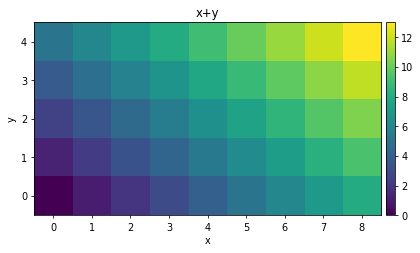

In [13]:
xx0 = np.linspace(0, 8, 9)
yy0 = np.linspace(0, 5, 5)
xx = 1*xx0[:, None] + 0*yy0[None, :]
yy = 0*xx0[:, None] + 1*yy0[None, :]

def plotarr(arr, *, title):
    plt.imshow(arr.T, origin='lower'); plt.gca().set(xlabel='x', ylabel='y', title=title)
    pc.colorbar(cax_mode='pc');   # <-- like plt.colorbar(), but prettier (not too tall)
plotarr(xx+yy, title='x+y')

yy  # <-- xx and yy are just numpy arrays, e.g.:

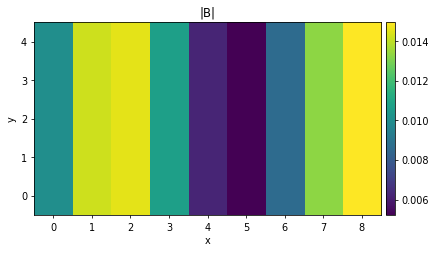

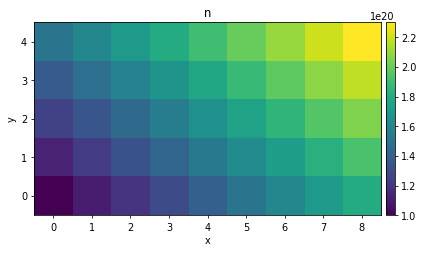

In [14]:
mod_B = 0.01 + 0.005 * np.sin(xx)
n = 1e20 + 1e19 * yy + 1e19 * xx   # [m^-3]
plotarr(mod_B, title='|B|'); plt.show()
plotarr(n, title='n'); plt.show()

q = 1.60218e-19  # alternatively: pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['qe']
m = 9.10938e-31  # alternatively: pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['me']
T = 2000   # [K]

In [15]:
# you can try to turn the numpy arrays directly into a dataset...
ds2 = xr.Dataset({'mod_B': mod_B, 'q': q, 'm': m, 'n': n, 'T': T})  # <-- crashes!!! (see below)

MissingDimensionsError: cannot set variable 'mod_B' with 2-dimensional data without explicit dimension names. Pass a tuple of (dims, data) instead.

#### Converting numpy arrays to xarray.DataArray (so that they can be entered into an xarray.Dataset)

In [16]:
# the crash^ is because for multi-dimensional arrays, you first need to specify the dimensions explicitly
#   by making xarray.DataArrays (instead of numpy arrays).
# You could just specify dimension names, and let xarray autofill coordinates when needed,
#   e.g., xr.DataArray(mod_B, dims=['x', 'y']).

# But, it can be really nice to track the coordinates as well:
mod_B_xarr = xr.DataArray(mod_B, dims=['x', 'y'], coords={'x': xx0, 'y': yy0})
n_xarr = xr.DataArray(n, dims=['x', 'y'], coords={'x': xx0, 'y': yy0})
n_xarr

<xarray.DataArray (x: 9, y: 5)> Size: 360B
1e+20 1.125e+20 1.25e+20 1.375e+20 ... 1.925e+20 2.05e+20 2.175e+20 2.3e+20
Coordinates:
  * x        (x) float64 72B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * y        (y) float64 40B 0.0 1.25 2.5 3.75 5.0

In [17]:
# now, inputting the xarray.DataArray objects instead of the numpy arrays, we can proceed:
ds2 = xr.Dataset({'mod_B': mod_B_xarr, 'q': q, 'm': m, 'n': n_xarr, 'T': T})
ds2

<xarray.Dataset> Size: 856B
Dimensions:  (x: 9, y: 5)
Coordinates:
  * x        (x) float64 72B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * y        (y) float64 40B 0.0 1.25 2.5 3.75 5.0
Data variables:
    mod_B    (x, y) float64 360B 0.01 0.01 0.01 0.01 ... 0.01495 0.01495 0.01495
    q        float64 8B 1.602e-19
    m        float64 8B 9.109e-31
    n        (x, y) float64 360B 1e+20 1.125e+20 1.25e+20 ... 2.175e+20 2.3e+20
    T        int64 8B 2000

#### Now that we have the dataset, we can proceed by making the calculator:

In [18]:
cc2 = pc.DimensionlessFromDatasetCalculator(ds2)
cc2

DimensionlessFromDatasetCalculator(ds=Dataset with sizes={'x': 9, 'y': 5}))

#### Let's put all those steps in one place, for easy reference:

In [19]:
### >> Putting it all into one cell for reference (just repeating cells from above) << ###

# make up some data
xx0 = np.linspace(0, 8, 9)
yy0 = np.linspace(0, 5, 5)
xx = 1*xx0[:, None] + 0*yy0[None, :]
yy = 0*xx0[:, None] + 1*yy0[None, :]

mod_B = 0.01 + 0.005 * np.sin(xx)
n = 1e20 + 1e19 * yy + 1e19 * xx   # [m^-3]

q = 1.60218e-19  # alternatively: pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['qe']
m = 9.10938e-31  # alternatively: pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['me']
T = 2000   # [K]

# converting numpy arrays to xarray.DataArray objects:
mod_B_xarr = xr.DataArray(mod_B, dims=['x', 'y'], coords={'x': xx0, 'y': yy0})
n_xarr = xr.DataArray(n, dims=['x', 'y'], coords={'x': xx0, 'y': yy0})

# creating the xarray.Dataset:
ds2 = xr.Dataset({'mod_B': mod_B_xarr, 'q': q, 'm': m, 'n': n_xarr, 'T': T})

# creating the PlasmaCalculator object:
cc2 = pc.DimensionlessFromDatasetCalculator(ds2)

#### Then we can use PlasmaCalcs to compute quantities and make plots!
_(using `arr.pc.image()` for plots, which is defined inside PlasmaCalcs.  
Analogous plotting routine `arr.plot.imshow()` is defined by xarray.  
Benefits of `arr.pc.image()` include: puts "x" on the x-axis by default, and easier to make movies later.)_

In [20]:
cc2('mod_B')  # <-- output is an xarray.DataArray, like before, though now it is 2D

<xarray.DataArray 'mod_B' (x: 9, y: 5)> Size: 360B
0.01 0.01 0.01 0.01 0.01 0.01421 ... 0.01495 0.01495 0.01495 0.01495 0.01495
Coordinates:
  * x        (x) float64 72B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * y        (y) float64 40B 0.0 1.25 2.5 3.75 5.0

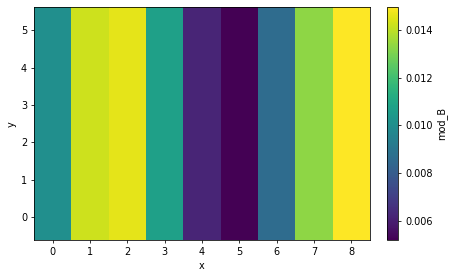

In [21]:
cc2('mod_B').pc.image();    # arr.pc.image() is like arr.plot.imshow(), or plt.imshow(arr), but slightly prettier.

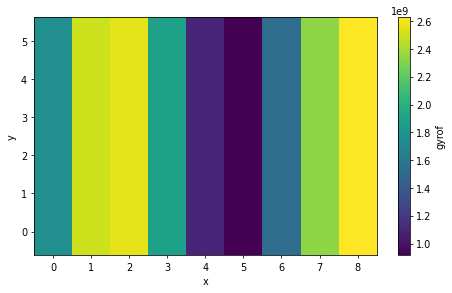

In [22]:
cc2('gyrof').pc.image();

'wplasma':
    "plasma frequency". wplasma = sqrt(n q^2 / (m epsilon0))
    This is analogous to the "true" plasma frequency of Langmuir oscillations,
        which is calculated using the same formula but applied to electrons.
    wplasma is equivalent to wplasmae if self.fluid is electrons.


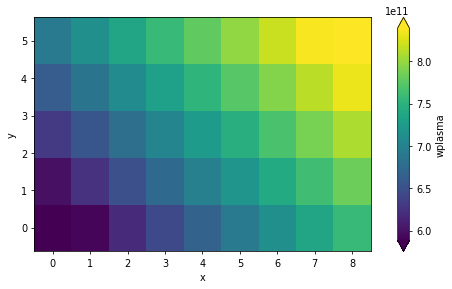

In [23]:
cc2.help('wplasma', only='exact')  # printing help about this var here again, for reference.
cc2('wplasma').pc.image();

'beta':
    plasma beta. beta = (pressure / magnetic pressure) = (P / (B^2 / (2 mu0)))


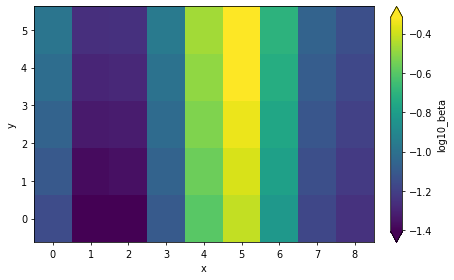

In [24]:
# other options are available, e.g. 'beta':
cc2.help('beta', only='exact')
cc2('log10_beta').pc.image();  # (could do just 'beta' to get linear scale results instead of log)

# 3) Working with vectors
Sweet, **now you know how to work with arrays of scalars. But what if you have vectors?**  
PlasmaCalcs handles vectors via the "component" dimension, and you should use the `ComponentHavingFromDatasetCalculator` class instead.

In [25]:
# make up some data
xx0 = np.linspace(0, 8, 9)
yy0 = np.linspace(0, 5, 5)
xx = 1*xx0[:, None] + 0*yy0[None, :]
yy = 0*xx0[:, None] + 1*yy0[None, :]

Bx_nparr = 0.01 + 0.005 * np.cos(xx)
By_nparr = 0.0
Bz_nparr = 0.01 + 0.005 * np.sin(yy)

q = pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['qe']
m = pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['me']

### Converting vector data into the format PlasmaCalcs expects…
The simplest way to do this is provided below, depending on whether you start with one array per component, or a single array.

_The expected format is that each vector quantity (e.g., "magnetic field" is one quantity) will be provided as a single xarray.DataArray,  
with "component" dimension, with coordinates equal to values from `pc.XYZ`_

#### (scenario I) If your starting point is one numpy array per component:

In [26]:
# first, be sure to convert to xarray.DataArray:
Bx = xr.DataArray(Bx_nparr, dims=['x', 'y'], coords={'x': xx0, 'y': yy0})
By = xr.DataArray(By_nparr, dims=['x', 'y'], coords={'x': xx0, 'y': yy0})
Bz = xr.DataArray(Bz_nparr, dims=['x', 'y'], coords={'x': xx0, 'y': yy0})

# then, you can just multiply appropriately by XHAT, YHAT, and ZHAT from PlasmaCalcs:
B = Bx * pc.XHAT + By * pc.YHAT + Bz * pc.ZHAT
B

<xarray.DataArray (x: 9, y: 5, component: 3)> Size: 1kB
0.015 0.0 0.01 0.015 0.0 0.01474 ... 0.009272 0.0 0.007142 0.009272 0.0 0.005205
Coordinates:
  * x          (x) float64 72B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * y          (y) float64 40B 0.0 1.25 2.5 3.75 5.0
  * component  (component) object 24B x y z

#### (scenario II) If your starting point is a single numpy array which already contains all relevant components:

In [27]:
# << in this cell, let's create array to match scenario II, with the same example data as above.
B_nparr = np.stack([Bx_nparr, By_nparr*xx*0, Bz_nparr])
#    ^ the *xx*0 reshapes the scalar By_nparr into an array of same shape as Bx_nparr and Bz_nparr
# (You would probably already have the array from your data source, and not need to worry about this cell)
B_nparr.shape

(3, 9, 5)

In [28]:
# now that we have the data...
# convert directly to xarray.DataArray, including 'component' dimension:
B = xr.DataArray(B_nparr, dims=['component', 'x', 'y'], coords={'component': pc.XYZ, 'x': xx0, 'y': yy0})
B

<xarray.DataArray (component: 3, x: 9, y: 5)> Size: 1kB
0.015 0.015 0.015 0.015 0.015 0.0127 ... 0.01 0.01474 0.01299 0.007142 0.005205
Coordinates:
  * component  (component) object 24B x y z
  * x          (x) float64 72B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * y          (y) float64 40B 0.0 1.25 2.5 3.75 5.0

### Making the dataset and PlasmaCalculator

In [29]:
ds = xr.Dataset({'B': B, 'q': q, 'm': m})
ds

<xarray.Dataset> Size: 1kB
Dimensions:    (component: 3, x: 9, y: 5)
Coordinates:
  * component  (component) object 24B x y z
  * x          (x) float64 72B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * y          (y) float64 40B 0.0 1.25 2.5 3.75 5.0
Data variables:
    B          (component, x, y) float64 1kB 0.015 0.015 ... 0.007142 0.005205
    q          float64 8B 1.602e-19
    m          float64 8B 9.109e-31

In [30]:
cc3 = pc.ComponentHavingFromDatasetCalculator(ds)
cc3

ComponentHavingFromDatasetCalculator(ds=Dataset with sizes={'component': 3, 'x': 9, 'y': 5}))

### Using PlasmaCalcs to load quantities and make plots!

In [31]:
cc3('B')

<xarray.DataArray 'B' (component: 3, x: 9, y: 5)> Size: 1kB
0.015 0.015 0.015 0.015 0.015 0.0127 ... 0.01 0.01474 0.01299 0.007142 0.005205
Coordinates:
  * component  (component) object 24B x y z
  * x          (x) float64 72B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * y          (y) float64 40B 0.0 1.25 2.5 3.75 5.0

hmmmm..., that result has 3 dimensions. How can we plot 3 dimensions at once?  
One way is to use subplots!

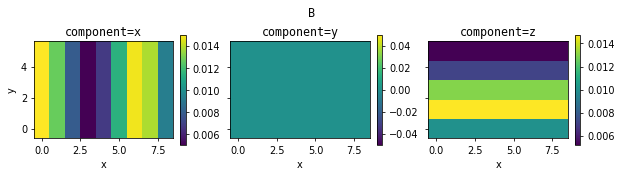

In [32]:
cc3('B').pc.subplots(row='component');

Another option is to create a movie:

In [ ]:
cc3('B').pc.image(t='component').ani()
# ^^ this should create a movie which looks like the gif below, and displays inline.
# (you can do a similar call for most PlasmaCalcs plotting routines,
#   e.g. arr.pc.subplots(...).ani() if your data varies across even more dimensions!)

# (In this example notebook, the next cell has html code to display an equivalent animation.
#   Using the .ani() syntax does not save the movie file long-term.
#   It is great for quickly exploring data on your own, but harder to share with other people.)

# To save to a file, you can use syntax like this, instead:
#   cc3('B').pc.image(t='component').save('examples_generated_movies/getting-started_from_dataset/cc3_B.gif', fps=0.5)
# which was used to generate the gif below (to create mp4, just use '.mp4' instead of '.gif').

<img src="examples_generated_movies/getting-started_from_dataset/cc3_B.gif" width="30%" height="30%" align="left"/>

Making a movie seems a bit silly when there are only 3 frames. But it might be useful later, if data varies in time.

#### Let's play around with some other available quantities:

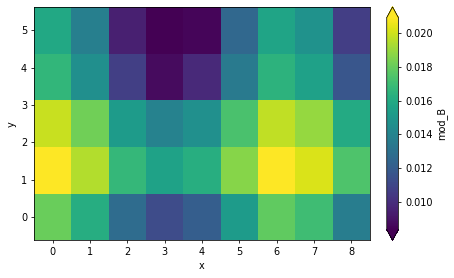

In [34]:
cc3('mod_B').pc.image();

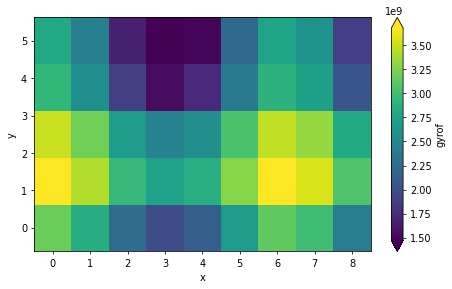

In [35]:
cc3('gyrof').pc.image();

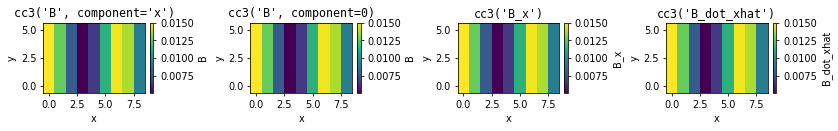

In [36]:
# to get a single component, there are a few different options, which are all numerically equivalent:
fig, axs = pc.subplots(ncols=4, squeeze=False)  # (like plt.subplots but slightly prettier and has more options)
cc3('B', component='x').pc.image(ax=axs[0,0], title="cc3('B', component='x')")
cc3('B', component=0).pc.image(ax=axs[0,1], title="cc3('B', component=0)")
cc3('B_x').pc.image(ax=axs[0,2], title="cc3('B_x')")
cc3('B_dot_xhat').pc.image(ax=axs[0,3], title="cc3('B_dot_xhat')");

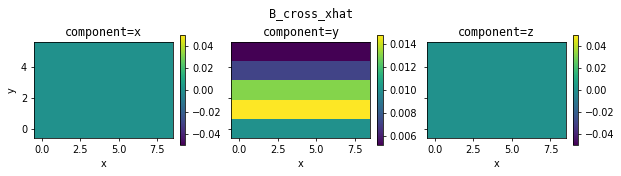

In [37]:
# cross products also exist:
cc3('B_cross_xhat').pc.subplots(row='component');

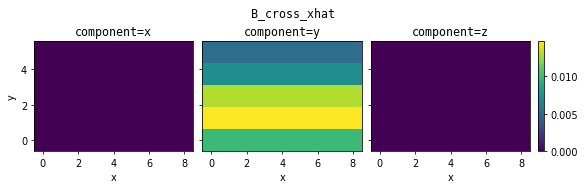

In [38]:
# let's use the same color scale for all plots to make things a bit clearer:
cc3('B_cross_xhat').pc.subplots(row='component', share_vlims='all');

In [39]:
# you can also look get multiple quantities simultaneously, by putting them in a list:
cc3(['B', 'B_cross_xhat', 'B_cross_yhat', 'B_cross_zhat', 'zhat_cross_B'])

<xarray.Dataset> Size: 6kB
Dimensions:       (component: 3, x: 9, y: 5)
Coordinates:
  * component     (component) object 24B x y z
  * x             (x) float64 72B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * y             (y) float64 40B 0.0 1.25 2.5 3.75 5.0
Data variables:
    B             (component, x, y) float64 1kB 0.015 0.015 ... 0.005205
    B_cross_xhat  (component, x, y) float64 1kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    B_cross_yhat  (component, x, y) float64 1kB -0.01 -0.01474 ... 0.009272
    B_cross_zhat  (component, x, y) float64 1kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    zhat_cross_B  (component, x, y) float64 1kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

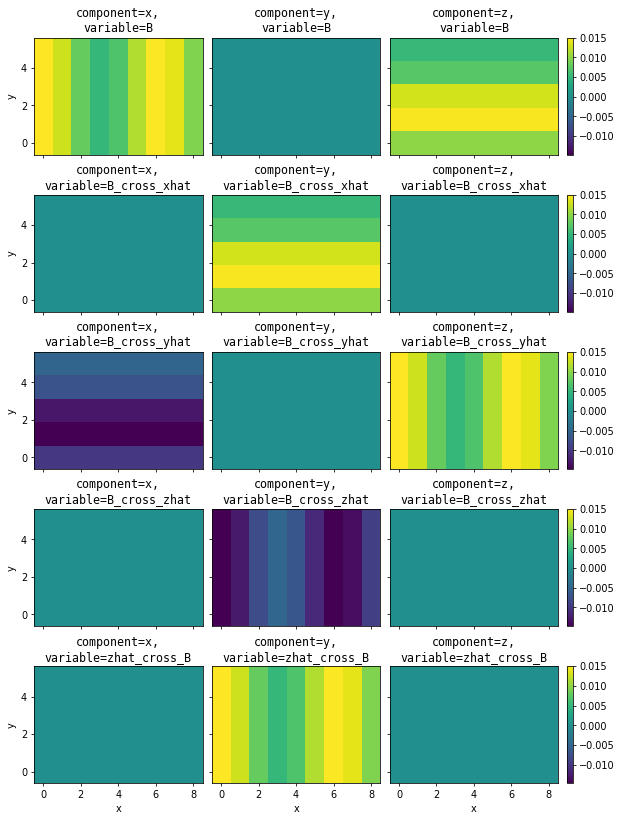

In [40]:
vals = cc3(['B', 'B_cross_xhat', 'B_cross_yhat', 'B_cross_zhat', 'zhat_cross_B'])
vals.pc.subplots(row='component', col='variable', share_vlims='all');

# note: there are many more customization options for pc.subplots -- but those go in another guide!
#  see help(vals.pc.subplots) for more options. picking one cool option to mention here;
#  consider something like: vals.pc.subplots(..., title='({variable})_{component}').

# 4) Working with time-varying data
If your data varies in time as well as space, you have two options:
- **a) treat the time dimension just like the space dimensions**; don't tell PlasmaCalcs to do anything special with it.
  - (this is the recommended option.)
  - especially easy if your data arrays already include the time dimension.
- **b) utilize PlasmaCalcs's "snap" objects and Snap dimension.**
  - may be easier if your data arrays don't include time yet. E.g., if you have a list of arrays, one per point in time.
  - uses `FromDatasetCalculator` class (subclass of `ComponentHavingFromDatasetCalculator`)
  - assumes vector quantities are input as vectors. E.g. input B, not mod_B.
  - requires creating a Snap opject at each point in time.
  - resulting behavior is closer to what the "hookups" do, e.g. closer to what EppicCalculator outputs might look like.

#### Option (a); treat the time dimension just like the space dimensions
Use this if time is just another axis along which your data varies.  
You don't need PlasmaCalcs to do anything particularly special with this dimension in particular.  

In [41]:
# example data - one array for each component of B (across all of space and time).
xx0 = np.linspace(0, 8, 9)
yy0 = np.linspace(0, 5, 5)
tt0 = np.linspace(0, 2, 4)
xx = 1*xx0[:, None, None] + 0*yy0[None, :, None] + 0*tt0[None, None, :]
yy = 0*xx0[:, None, None] + 1*yy0[None, :, None] + 0*tt0[None, None, :]
tt = 0*xx0[:, None, None] + 0*yy0[None, :, None] + 1*tt0[None, None, :]

Bx_nparr = 0.01 + 0.005 * np.cos(xx) + 0.003 * tt
By_nparr = 0.0
Bz_nparr = 0.01 + 0.005 * np.sin(yy) - 0.003 * tt

q = pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['qe']
m = pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['me']

# converting to xarray.DataArray (just like in Section (3), but now we have a time dimension too)
Bx = xr.DataArray(Bx_nparr, dims=['x', 'y', 't'], coords={'x': xx0, 'y': yy0, 't': tt0})
By = xr.DataArray(By_nparr, dims=['x', 'y', 't'], coords={'x': xx0, 'y': yy0, 't': tt0})
Bz = xr.DataArray(Bz_nparr, dims=['x', 'y', 't'], coords={'x': xx0, 'y': yy0, 't': tt0})

B = Bx * pc.XHAT + By * pc.YHAT + Bz * pc.ZHAT
B

<xarray.DataArray (x: 9, y: 5, t: 4, component: 3)> Size: 4kB
0.015 0.0 0.01 0.017 0.0 0.008 ... 0.01327 0.0 0.001205 0.01527 0.0 -0.0007946
Coordinates:
  * x          (x) float64 72B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * y          (y) float64 40B 0.0 1.25 2.5 3.75 5.0
  * t          (t) float64 32B 0.0 0.6667 1.333 2.0
  * component  (component) object 24B x y z

In [42]:
# make dataset
ds = xr.Dataset({'B': B, 'q': q, 'm': m})

# make calculator
cc4a = pc.ComponentHavingFromDatasetCalculator(ds)
cc4a

ComponentHavingFromDatasetCalculator(ds=Dataset with sizes={'x': 9, 'y': 5, 't': 4, 'component': 3}))

In [43]:
cc4a('B')  # getting vars works the same way before! Same interface regardless of input dimensions.

<xarray.DataArray 'B' (x: 9, y: 5, t: 4, component: 3)> Size: 4kB
0.015 0.0 0.01 0.017 0.0 0.008 ... 0.01327 0.0 0.001205 0.01527 0.0 -0.0007946
Coordinates:
  * x          (x) float64 72B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * y          (y) float64 40B 0.0 1.25 2.5 3.75 5.0
  * t          (t) float64 32B 0.0 0.6667 1.333 2.0
  * component  (component) object 24B x y z

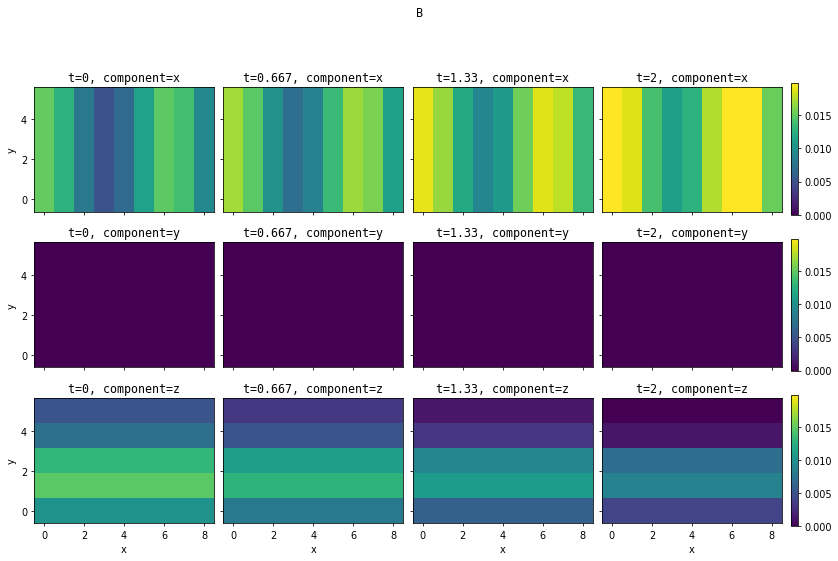

In [44]:
cc4a('B').pc.subplots(col='component', row='t', share_vlims='all');

In [45]:
cc4a('gyrof')

<xarray.DataArray 'gyrof' (x: 9, y: 5, t: 4)> Size: 1kB
3.171e+09 3.305e+09 3.504e+09 3.76e+09 ... 1.87e+09 2.061e+09 2.344e+09 2.69e+09
Coordinates:
  * x        (x) float64 72B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * y        (y) float64 40B 0.0 1.25 2.5 3.75 5.0
  * t        (t) float64 32B 0.0 0.6667 1.333 2.0

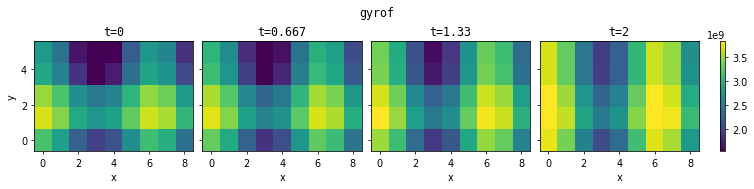

In [46]:
cc4a('gyrof').pc.subplots(row='t', share_vlims='all');

**Quick note about computational efficiency**  
To save computational power while exploring the data, you might want to get values at only a few points in time.  
You also might want to get values at only a certain region of space.  
For hookups, you can do this slicing internally, immediately after loading values from files, via the `slices` option.  
However, for calculators from datasets, the `slices` option is not available.  
Instead, just create a new calculator with the sliced dataset!

In [47]:
# example (gets first 5 points in x, every other point in y, and only the first and last points in t)
desired_slices = dict(x=slice(0, 5, None), y=slice(None, None, 2), t=[0,-1])
ds_sliced = cc4a.ds.isel(desired_slices)
cc4a_sliced = pc.ComponentHavingFromDatasetCalculator(ds_sliced)
# equivalent, more convenient, and works for any type of FromDatasetCalculator:
#   cc4a_sliced = cc4a.with_isel(desired_sliced)
cc4a_sliced

ComponentHavingFromDatasetCalculator(ds=Dataset with sizes={'x': 5, 'y': 3, 't': 2, 'component': 3}))

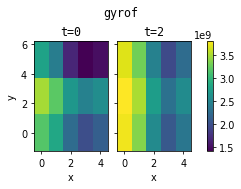

In [48]:
cc4a_sliced('gyrof').pc.subplots(row='t', share_vlims='all');

#### Option (b); utilize PlasmaCalcs's "snap" objects and Snap dimension.
  - uses `FromDatasetCalculator` class (subclass of `ComponentHavingFromDatasetCalculator`)
  - assumes vector quantities are input as vectors. E.g. input B, not mod_B.
  - requires creating a Snap opject at each point in time.
  - resulting behavior is closer to what the "hookups" do, e.g. closer to what EppicCalculator outputs might look like.

In [49]:
# example data - one array per point in time, for each component of B (across all of space).
xx0 = np.linspace(0, 8, 9)
yy0 = np.linspace(0, 5, 5)
xx = 1*xx0[:, None] + 0*yy0[None, :]
yy = 0*xx0[:, None] + 1*yy0[None, :]

tt0 = np.linspace(0, 2, 4)

Bx_nparr_list = [0.01 + 0.005 * np.cos(xx) + 0.003 * t for t in tt0]
By_nparr_list = [0.0 for t in tt0]
Bz_nparr_list = [0.01 + 0.005 * np.sin(yy) - 0.003 * t for t in tt0]

q = pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['qe']
m = pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['me']

In [50]:
# now, make one snap per point in time. Each snap can have a name, index, and time.
# Here, let's make the names just be 'snapN', with N equal to the index.
# (the names are especially convenient when instead using PlasmaCalcs hookups, since they can relate directly to filenames.)
snaps = [pc.Snap(f'snap{N}', N, t=tval) for N, tval in enumerate(tt0)]
snaps

[Snap('snap0', 0, t=0.000e+00),
 Snap('snap1', 1, t=6.667e-01),
 Snap('snap2', 2, t=1.333e+00),
 Snap('snap3', 3, t=2.000e+00)]

In [51]:
# now, make DataArrays appropriately:
Bx_list = [xr.DataArray(Bx_nparr_list[i], dims=['x', 'y'], coords={'x': xx0, 'y': yy0, 'snap': snaps[i], 't': tt0[i]}) for i in range(len(snaps))]
By_list = [xr.DataArray(By_nparr_list[i], dims=['x', 'y'], coords={'x': xx0, 'y': yy0, 'snap': snaps[i], 't': tt0[i]}) for i in range(len(snaps))]
Bz_list = [xr.DataArray(Bz_nparr_list[i], dims=['x', 'y'], coords={'x': xx0, 'y': yy0, 'snap': snaps[i], 't': tt0[i]}) for i in range(len(snaps))]

Bx = xr.concat(Bx_list, 'snap')
By = xr.concat(By_list, 'snap')
Bz = xr.concat(Bz_list, 'snap')

B = Bx * pc.XHAT + By * pc.YHAT + Bz * pc.ZHAT
B

<xarray.DataArray (snap: 4, x: 9, y: 5, component: 3)> Size: 4kB
0.015 0.0 0.01 0.015 0.0 0.01474 ... 0.01527 0.0 0.001142 0.01527 0.0 -0.0007946
Coordinates:
  * x          (x) float64 72B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * y          (y) float64 40B 0.0 1.25 2.5 3.75 5.0
  * snap       (snap) object 32B snap0 snap1 snap2 snap3
    t          (snap) float64 32B 0.0 0.6667 1.333 2.0
  * component  (component) object 24B x y z

In [52]:
# make dataset
ds = xr.Dataset({'B': B, 'q': q, 'm': m})

# make calculator
cc4b = pc.FromDatasetCalculator(ds)
cc4b

FromDatasetCalculator(ds=Dataset with sizes={'x': 9, 'y': 5, 'snap': 4, 'component': 3}))

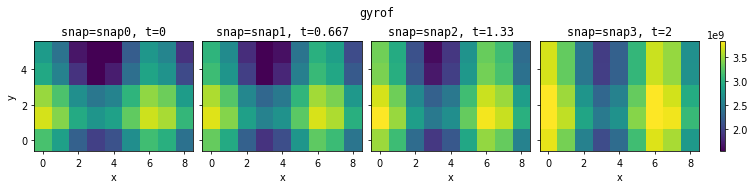

In [53]:
cc4b('gyrof').pc.subplots(row='snap', share_vlims='all');

**Benefits of using snap dimension:**
- (i) you can provide human-readable snap names (see above, where names were entered)
- (ii) you can easily swap between 't' and 'snap' dimensions.
  - (some xarray routines expect referenced values to be a dimension, not just a coordinate, e.g. `arr.mean(dim)`)
- (iii) you can easily choose a subset of snaps at which to get values

In [54]:
## for benefit (ii). Here is how to swap between the dimensions:
arr = cc4b('gyrof')
swapped_way1 = arr.swap_dims({'snap':'t'})  # way 1 (note: outputs swapped version, but original arr remains unchanged)
swapped_way2 = arr.pc.promote_dim('t')  # way 2 (note: outputs swapped version, but original arr remains unchanged)
# way1 and way2 produce the same results.
# way2 is slightly easier to use, because if 't' was already a dimension, it won't crash.
#   e.g., swapped_way2.pc.promote_dim('t') returns swapped_way2, unchanged.
swapped_way2

<xarray.DataArray 'gyrof' (t: 4, x: 9, y: 5)> Size: 1kB
3.171e+09 3.699e+09 3.49e+09 2.922e+09 ... 2.954e+09 2.694e+09 2.69e+09
Coordinates:
  * x        (x) float64 72B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * y        (y) float64 40B 0.0 1.25 2.5 3.75 5.0
    snap     (t) object 32B snap0 snap1 snap2 snap3
  * t        (t) float64 32B 0.0 0.6667 1.333 2.0

In [55]:
## for benefit (iii). Here is how to get values at only a few snapshots:
cc4b('gyrof', snap=[0,2])  # get at snaps 0 and 2
cc4b('gyrof', snap='snap1')  # get at only snap1
cc4b('gyrof', snap=slice(0,None,3))  # get every third snap
cc4b('gyrof', snap=[1, 'snap2', 0])  # get at snap 1, 'snap2', and snap 0

<xarray.DataArray 'gyrof' (snap: 3, x: 9, y: 5)> Size: 1kB
3.305e+09 3.737e+09 3.561e+09 3.124e+09 ... 2.807e+09 2.059e+09 1.87e+09
Coordinates:
  * x        (x) float64 72B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * y        (y) float64 40B 0.0 1.25 2.5 3.75 5.0
  * snap     (snap) object 24B snap1 snap2 snap0
    t        (snap) float64 24B 0.6667 1.333 0.0

In [56]:
# more advanced info about snaps:
cc4b.snaps  # full list of all possible snaps

SnapList(len=4; Snap('snap0', 0, t=0.000e+00), ..., Snap('snap3', 3, t=2.000e+00))

In [57]:
cc4b.snap  # current value of 'snap' (tells snaps at which to get result, if 'snap' not provided during call.)

SnapList(len=4; Snap('snap0', 0, t=0.000e+00), ..., Snap('snap3', 3, t=2.000e+00))

In [58]:
# set current snap with any of the options above, or explicitly from .snaps.
# examples:
cc4b.snap = [0,2]
print(cc4b.snap)

cc4b.snap = slice(0,None,3)
print(cc4b.snap)

cc4b.snap = 'snap1'
print(cc4b.snap)

cc4b.snap = [1, 'snap2', 0]
print(cc4b.snap)

cc4b.snap = cc4b.snaps[0,2]
print(cc4b.snap)

cc4b.snap = cc4b.snaps[::3]
print(cc4b.snap)

cc4b.snap = cc4b.snaps[1]
print(cc4b.snap)

[Snap('snap0', 0, t=0.000e+00), Snap('snap2', 2, t=1.333e+00)]
SnapList(snap0, snap3)
snap1
[Snap('snap1', 1, t=6.667e-01), Snap('snap2', 2, t=1.333e+00), Snap('snap0', 0, t=0.000e+00)]
SnapList(snap0, snap2)
SnapList(snap0, snap3)
snap1


In [59]:
# when getting value, only gets value at current snap:
print(cc4b.snap)
cc4b('gyrof')

snap1


<xarray.DataArray 'gyrof' (x: 9, y: 5)> Size: 360B
3.305e+09 3.737e+09 3.561e+09 3.124e+09 ... 2.769e+09 2.179e+09 2.061e+09
Coordinates:
  * x        (x) float64 72B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * y        (y) float64 40B 0.0 1.25 2.5 3.75 5.0
    snap     object 8B snap1
    t        float64 8B 0.6667

# 5) Working with multiple species
Often in plasma physics, we care about multiple species, which might all behave differently (E.g., electrons, protons, neutrals, heavy ions).  
PlasmaCalcs handles this by having a "fluid" dimension  
(which, technically tracks the "species", even if using a non-fluid model such as a kinetic model;  
it's called "fluid" because "fluid" is slightly easier to type than "species").

The way to handle this is to make `pc.Fluid` objects and assign them as coordinates for `"fluid"`, in your input arrays,  
and use the `pc.MultifluidFromDatasetCalculator` class (or `SnaplessMultifluidFromDatasetCalculator` if not using snaps).  

_(Note: there is currently no default option for "snapless and vectorless multifluid from dataset calculator".  
If you need that, contact PlasmaCalcs developers or follow existing patterns in PlasmaCalcs/other_calculators/from_dataset.py)_  

Below is similar to the example in section (4) above, but here uses charges and masses for multiple species, not just electrons.

In [60]:
# example data: q, m, and n varying across multiple species.
q_e = pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['qe']  # electron charge, in si units
m_e = pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['me']  # electron mass, in si units
m_amu = pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['amu']  # 1 amu, in si units

# note: Fluid expects m and q in elementary units (m=1 means 1 amu, and q=1 means 1 |electron charge|)
fluids = [pc.Fluid('electrons', i=0, m=m_e/m_amu, q=-1),
          pc.Fluid('protons', i=1, m=1, q=+1),
          pc.Fluid('neutral_H', i=2, m=1, q=0)]

q = xr.DataArray([f.q * q_e for f in fluids], dims=['fluid'], coords={'fluid': fluids})
m = xr.DataArray([f.m * m_amu for f in fluids], dims=['fluid'], coords={'fluid': fluids})

# let's just do something simple for B, here. Could also do B varying in space and/or time, like in previous examples.
B = xr.DataArray([0, 0, 0.01], dims=['component'], coords={'component': pc.XYZ})

# make dataset and calculator
ds = xr.Dataset({'B': B, 'q': q, 'm': m})

cc5 = pc.SnaplessMultifluidFromDatasetCalculator(ds)
cc5

SnaplessMultifluidFromDatasetCalculator(ds=Dataset with sizes={'component': 3, 'fluid': 3}))

In [61]:
cc5('gyrof')   # <-- crashes!!! (see below)

AttributeError: jfluids hasn't been set yet!
(self=<PlasmaCalcs.dimensions.fluids.jFluidDimension object at 0x7fc1585d65e0>)
You can use: jfluids=None, to disable this error, but it will also disable the 'smart' behavior of setting/getting self.jfluid.
(Note: that 'smart' behavior may have triggered this error message, by trying to get self.jfluids.)
See help(type(self).jfluid) for more info.
You can also use: del self.jfluids, to re-enable this error.

In [62]:
# Uh-oh, looks like we need to set jfluids if we want to use fluids...
# For now, let's just do the workaround suggested in the error message: jfluids=None
cc5.jfluids = None

In [63]:
cc5('gyrof')

<xarray.DataArray 'gyrof' (fluid: 3)> Size: 24B
1.759e+09 9.649e+05 0.0
Coordinates:
  * fluid    (fluid) object 24B electrons protons neutral_H

#### jfluids: collisions
jfluids exists because some quantities, like collision frequency, care about interaction between two fluids.

In [64]:
# using the data above, but adding more info:
n = xr.DataArray([1e16, 1e16, 1e20], dims=['fluid'], coords={'fluid': fluids})
T = 2000   # or, could do a T that depends on species. But, that's not necessary!

# make dataset and calculator
ds = xr.Dataset({'B': B, 'q': q, 'm': m, 'n': n, 'T': T})

cc5b = pc.SnaplessMultifluidFromDatasetCalculator(ds)

# assign jfluids explicitly (it isn't handled by default because none of the inputs in ds care about jfluid)
cc5b.jfluids = cc5b.fluids
# (if you know some collision frequencies, include 'nusj' in the input dataset, varying across "fluid" and "jfluid" dimensions.)

In [65]:
# Now we can compute collision frequencies, e.g.:
cc5b.help('nusj_maxwell', only='exact')
cc5b('nusj_maxwell', fluid=['electrons', 'protons'], jfluid='neutral_H')

'nusj_maxwell':
    maxwell collision frequency.
    "frequency for one particle of s (self.fluid) to collide with any of j (self.jfluid)."
    This is a good model for nusj when:
        - s or j is neutral hydrogen.
            (assumed by the implementation here; could be improved in the future)
        - the charged species is a heavy ion.
            (collisions between [e-,H] and [H+,H] behave differently.)
    
    nusj_maxwell = (1 Hz) * (1.95856) * n_j * sqrt(
                    (alpha_n * q_e^2 / eps0) * (m_j / (m_s * (m_s + m_j)))
                    ), where:
        n_j = number density of j [si units, i.e. meters^-3]
        alpha_n = polarizability of neutral hydrogen. [si units, i.e. meters^3]
        q_e = charge of electron. [si units, i.e. C]
        eps0 = permittivity of free space; standard definition for eps0. [si units]
        m_s, m_j = mass of s, j. [si units, i.e. kg]
    
    (formula from Oppenheim+2020, Appendix A.)


<xarray.DataArray 'nusj_maxwell' (fluid: 2)> Size: 16B
9.021e+06 1.495e+05
Coordinates:
    jfluid   object 8B neutral_H
  * fluid    (fluid) object 16B electrons protons

In [66]:
cc5b.help('nusj_coulomb', only='exact')
cc5b('nusj_coulomb', fluid='electrons', jfluid='protons')

'nusj_coulomb':
    coulomb collision frequency.
    "frequency for one particle of s (self.fluid) to collide with any of j (self.jfluid)."
    This is a good model for nusj when:
        - s & j are both charged species.
    
    nusj_coulomb = (1 Hz) * (1.7/20) * (ln(Lambda))
                    * (m_p/m_s) * (m_sj/m_p)^(1/2)
                    * (T_sj / Kelvin)^(-3/2)
                    * (q_s/q_e)^2 * (q_j/q_e)^2
                    * (n_j / (10^6 meters^-3)), where:
        ln(Lambda) = Coulomb logarithm (see self.help('coulomb_logarithm') for details)
        n_j = number density of j (self.jfluid).
        m_sj = weighted mass = m_s * m_j / (m_s + m_j)
        T_sj = mass-weighted temperature = (m_s * T_j + m_j * T_s) / (m_s + m_j)
        m_p = mass of proton
        q_e = charge of electron
        m_s, m_j = mass of s, j
        T_s, T_j = temperature of s, j.
        q_s, q_j = charge of s, j


<xarray.DataArray 'nusj_coulomb' ()> Size: 8B
3.694e+06
Coordinates:
    fluid    object 8B electrons
    jfluid   object 8B protons

In [67]:
# if you don't input values for fluid and jfluid, you get results for all of them:
cc5b('nusj_maxwell')

# for nusj in PlasmaCalcs, result is 0 for self-self collisions, which is why the diagonal is all 0.

<xarray.DataArray 'nusj_maxwell' (jfluid: 3, fluid: 3)> Size: 72B
0.0 0.4949 0.4949 902.1 0.0 14.95 9.021e+06 1.495e+05 0.0
Coordinates:
  * jfluid   (jfluid) object 24B electrons protons neutral_H
  * fluid    (fluid) object 24B electrons protons neutral_H

In [68]:
# currently, getting 'nusj' directly for a FromDatasetCalculator is not implemented.
#  (This enables providing nusj directly in the dataset itself,
#   and ensures a crash if you were expecting nusj to be input directly but it is missing,
#   rather than silently accidentally giving incorrect results.)
# cc5b('nusj')  # <-- crashes

# The default of 'nusj' is to get the "most appropriate" collision frequency.
# As a temporary workaround, you can explicitly use 'nusj_best' instead:
cc5b.help('nusj_best', only='exact')
cc5b('nusj_best')

'nusj_best':
    collision frequency, using self.collisions_mode='best'.
    "frequency for one particle of s (self.fluid) to collide with any of j (self.jfluid)."
    Uses the appropriate formula based on self.fluid & self.jfluid.
    Use coulomb for charge-charge, fromtable if table exists, maxwell otherwise.


<xarray.DataArray 'nusj_best' (jfluid: 3, fluid: 3)> Size: 72B
0.0 2.026e+03 0.4949 3.694e+06 0.0 14.95 9.021e+06 1.495e+05 0.0
Coordinates:
  * fluid    (fluid) object 24B electrons protons neutral_H
  * jfluid   (jfluid) object 24B electrons protons neutral_H

**collisions note:** for electron/proton collisions with neutral hydrogen, lookup tables exist, and are likely more physically accurate than the simple maxwell molecule formula. If using collisions in your work, consider looking further into how to utilize those tables (start by looking into `cc5b.help('collisions_cross_section')`); the mcode above does not utilize them.

**What if you have multiple species and values vary in space, time, and/or across vector components?**  
E.g., velocity values across space and time for each species (with ux, uy, and uz components)...  

In that case, just follow the patterns in previous sections for the space, time, and vector component variations.  
And, follow the pattern in this section to add the additional "fluid" dimension.  

There aren't any "new" concepts required to handle this situation, it's just combining things from above!

# 6) Summary, and learning about existing options

To summarize, here are the different types of `FromDatasetCalculator` objects you might want to use, and why you might use them:
- **`pc.DimensionlessFromDatasetCalculator`**: useful for making simple examples, working with non-vectors that vary only across dimensions PlasmaCalcs doesn't treat specially (e.g., varying across space).
- **`pc.ComponentHavingFromDatasetCalculator`**: similar to DimensionlessFromDatasetCalculator, but allows to work with vectors. Expects at least one input quantity to have "component" dimension, with `pc.Component` objects indicating vector components.
- **`pc.FromDatasetCalculator`**: similar to ComponentHavingFromDatasetCalculator, but allows to work with snapshots. Expects at least one input quantity to have "snap" dimension (and associated "t" coordinate), with `pc.Snap` objects indicating snapshots.
  - if you have time-varying data, there are some benefits to using Snaps, but it requires a bit more work to set up, and you might be perfectly happy just treating the time dimension as something PlasmaCalcs doesn't care about (and just using one of the prior two options instead).
- **`pc.MultifluidFromDatasetCalculator`**: similar to FromDatasetCalculator, but allows to work with multiple species. Expects at least one input quantity to have "fluid" dimension, with `pc.Fluid` objects indicating species.
  - also expects least one quantity may have the "jfluid" dimension, with `pc.Fluid` objects indicating species.

_The "expected" dimensions are not necessarily required, to create the calculator in the first place.  
But, if you are missing one of the expected dimensions, relevant quantities may crash.  
The workaround is to set the relevant attribute to "none".  
E.g., to use a MultifluidFromDatasetCalculator from a dataset without "jfluid", set `cc.jfluids=None` after creating the calculator `cc`._

Similar to above, but expecting different combinations of dimensions:
- **`pc.SnaplessMultifluidFromDatasetCalculator`**: expects "component", "fluid", and "jfluid" dimensions in input. Does not recognize "snap" as a special dimension.
- **`pc.VectorlessFromDatasetCalculator`**: expects "snap" dimension in input. Does not recognize "component", "fluid", and "jfluid" as special dimensions.
- **`pc.VectorlessMultifluidFromDatasetCalculator`**: expects "snap", "fluid", and "jfluid" dimensions in input. Does not recognize "component" as a special dimension.

### Existing options — what can you input when making a FromDatasetCalculator?
To learn what can be input, call help() on the relevant class.

In [69]:
# e.g.: help(pc.FromDatasetCalculator)
# prints something like:

'''Help on class FromDatasetCalculator in module PlasmaCalcs.other_calculators.from_dataset:

class FromDatasetCalculator(InfersSnapsFromDataset, ComponentHavingFromDatasetCalculator, PlasmaCalcs.plasma_calculator.PlasmaCalculator)
 |  FromDatasetCalculator(ds, **kw_super)
 |  
 |  PlasmaCalculator taking a Dataset as input. Knows about snaps and components dimensions.
 |  Infers snaps and components from dataset if possible.
 |  
 |  ds: xarray.Dataset
 |      self(var) looks in self.ds when can't find another way to compute var.
 |      For base vars, always checks ds first.
 |      (base vars): ds, q, gamma, E, B, m, n, u, T, nusj,
 |                       m_neutral, n_neutral, u_neutral, T_neutral.
 |      For simple derived vars, check ds first; compute from base vars if missing.
 |      (simple derived vars): r, p, P, Tjoule, e, nusn, nq, Jf, J, E_un0.
 ...
 
 '''

# the help string is quite long, since there are many inherited functions,
# but the relevant part is at the top; see the list of (base vars) and (simple derived vars) above!

# for help on what each var means, do pc.FromDatasetCalculator.cls_help(var), e.g.:
pc.FromDatasetCalculator.cls_help('T', only='exact')

'T':
    temperature. "maxwellian" temperature (classical T in thermodynamics).
    The implementation here just does self.load_direct('T').


# 7) Bonus: testing different values / "artificial" scaling
The FromDatasetCalculator interface is especially powerful because it makes testing different values very easy.

For example, maybe you have data for lots of different quantities, and you have built a whole set of analysis routines using PlasmaCalcs to compute different outputs.  
But then, you realize, you want to ask, "how do all my results change if I make the magnetic field 10x stronger, or 10x weaker?"

That's easy to check! See example below.

In [70]:
# make up some data
xx0 = np.linspace(0, 8, 9)
yy0 = np.linspace(0, 5, 5)
xx = 1*xx0[:, None] + 0*yy0[None, :]
yy = 0*xx0[:, None] + 1*yy0[None, :]

Bx_nparr = 0.01 + 0.005 * np.cos(xx)
By_nparr = 0.0
Bz_nparr = 0.01 + 0.005 * np.sin(yy)

B_nparr = np.stack([Bx_nparr, By_nparr*xx*0, Bz_nparr])

q = pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['qe']
m = pc.DEFAULTS.PHYSICAL.CONSTANTS_SI['me']

# convert to xarray as needed:
B = xr.DataArray(B_nparr, dims=['component', 'x', 'y'], coords={'component': pc.XYZ, 'x': xx0, 'y': yy0})

# make dataset:
ds = xr.Dataset({'B': B, 'q': q, 'm': m})

# make calculator
cc7 = pc.ComponentHavingFromDatasetCalculator(ds)

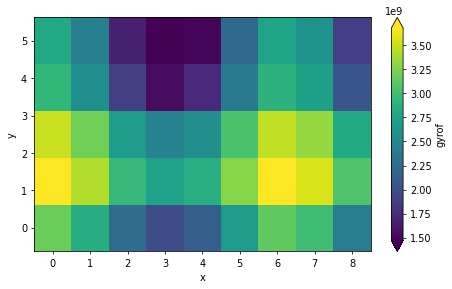

In [71]:
cc7('gyrof').pc.image();  # baseline gyrofrequency, before changing B

In [72]:
# now let's see how results change when B gets "artificially" increased or decreased!
# the main idea is that we will make an xarray.DataArray of multiplier values,
#   along a new dimension (we will call it "artificial_Bmul" below)

Bmul_vals = [0.25, 0.5, 1, 2, 4]
Bmul = xr.DataArray(Bmul_vals, dims=['artificial_Bmul'], coords={'artificial_Bmul': Bmul_vals})
Bmul

<xarray.DataArray (artificial_Bmul: 5)> Size: 40B
0.25 0.5 1.0 2.0 4.0
Coordinates:
  * artificial_Bmul  (artificial_Bmul) float64 40B 0.25 0.5 1.0 2.0 4.0

In [73]:
# now, let's make a dataset using the new B instead:
ds = cc7.ds.assign({'B': Bmul * cc7.ds['B']})
ds

<xarray.Dataset> Size: 6kB
Dimensions:          (component: 3, x: 9, y: 5, artificial_Bmul: 5)
Coordinates:
  * component        (component) object 24B x y z
  * x                (x) float64 72B 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0
  * y                (y) float64 40B 0.0 1.25 2.5 3.75 5.0
  * artificial_Bmul  (artificial_Bmul) float64 40B 0.25 0.5 1.0 2.0 4.0
Data variables:
    B                (artificial_Bmul, component, x, y) float64 5kB 0.00375 ....
    q                float64 8B 1.602e-19
    m                float64 8B 9.109e-31

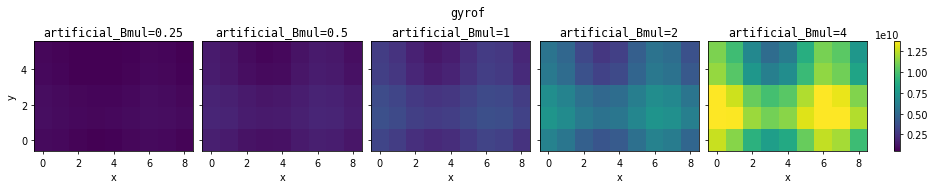

In [74]:
cc7b = pc.ComponentHavingFromDatasetCalculator(ds)
cc7b('gyrof').pc.subplots(row='artificial_Bmul', share_vlims='all');

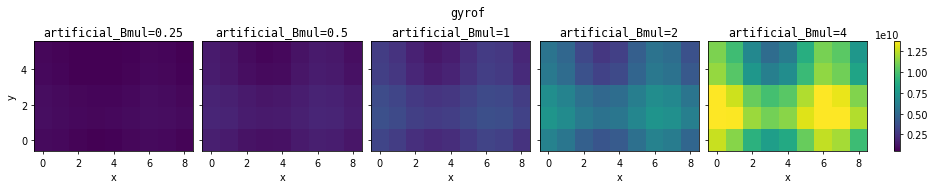

In [75]:
# this pattern of "scale some values artificially" is common and useful enough that PlasmaCalcs provides shorthands:

# for making the artificial scaling:
Bmul = pc.xr1d([0.25, 0.5, 1, 2, 4], name='artificial_Bmul')

# for making the FromDatasetCalculator which includes the scaling:
cc7c = cc7.with_scaling({'B': Bmul})

# (plotting again to show the results are the same)
cc7c('gyrof').pc.subplots(row='artificial_Bmul', share_vlims='all');